In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
from sqlalchemy import desc
most_recent_date = session.query(Base.classes.measurement.date).order_by(desc(Base.classes.measurement.date)).first()
print(most_recent_date)

('2017-08-23',)


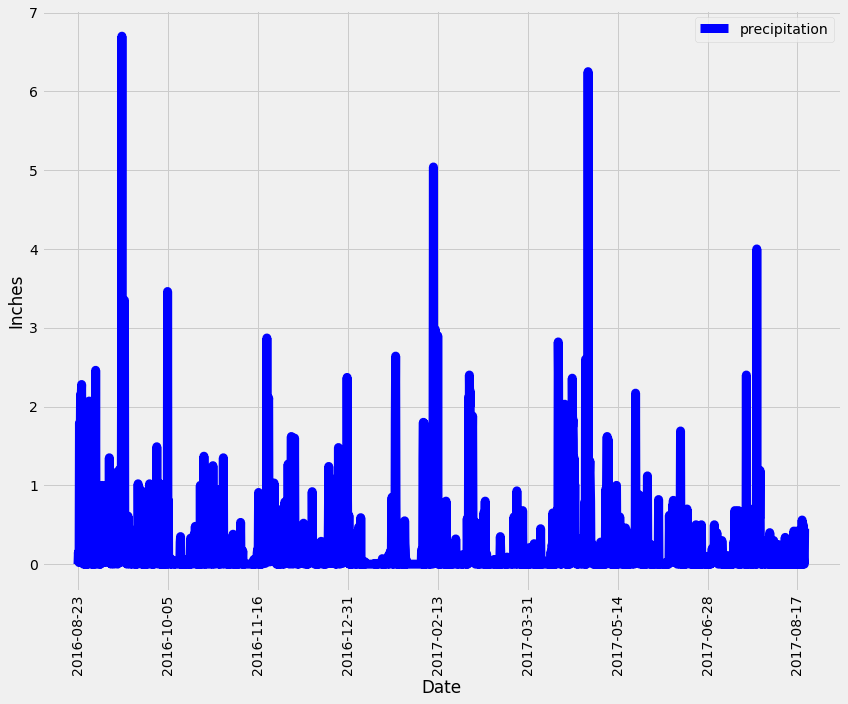

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Base.classes.measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
last_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_back = latest_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Base.classes.measurement.date, Base.classes.measurement.prcp) \
    .order_by(Base.classes.measurement.date.asc()) \
    .filter(Base.classes.measurement.date >= one_year_back) \
    .all()
# Save the query results as a Pandas DataFrame and set the index to the date column
q_results = pd.DataFrame(results, columns=['Date', 'Precipitation'])
q_results = q_results.rename(columns={"Precipitation": "precipitation"})

# Sort the dataframe by date
q_results = q_results.sort_values(by=['Date'], ascending=True)
q_results = q_results.dropna()
q_results = q_results.reset_index(drop=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax = q_results.plot(x='Date', y='precipitation', color='b', figsize=(12, 10), legend=True, linewidth=9.0, grid=True)
ax.set_ylabel("Inches")
plt.setp(ax.get_xticklabels(), visible=True)
plt.xticks(rotation=90)
plt.tight_layout()
plt.xlabel("Date")
plt.show()


In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
q_results.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Base.classes.station.station)).scalar()
total_stations

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Base.classes.measurement.station, func.count(Base.classes.measurement.station)) \
                         .group_by(Base.classes.measurement.station) \
                         .order_by(func.count(Base.classes.measurement.station).desc()) \
                         .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
        filter(measurement.station==active_stations[0][0]).all()
temps

[(54.0, 85.0, 71.66378066378067)]

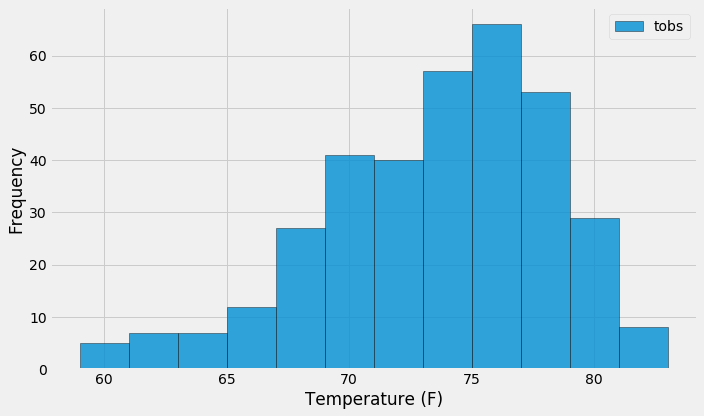

In [59]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from datetime import datetime, timedelta
temps = session.query(func.min(Base.classes.measurement.tobs),
                      func.max(Base.classes.measurement.tobs),
                      func.avg(Base.classes.measurement.tobs)) \
              .filter(Base.classes.measurement.station == active_stations[0][0]) \
              .all()
results_date = session.query(func.max(Base.classes.measurement.date)).scalar()
latest_date = datetime.strptime(results_date, "%Y-%m-%d")
one_year_ago = latest_date - timedelta(days=365)

results = session.query(Base.classes.measurement.tobs) \
                .filter(Base.classes.measurement.station == active_stations[0][0]) \
                .filter(Base.classes.measurement.date >= one_year_ago.strftime('%Y-%m-%d')) \
                .all()

df_results = pd.DataFrame(results, columns=['Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(df_results['Temperature'], bins=12, edgecolor='black', alpha=0.8)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.tight_layout()
plt.show()

# Close Session

In [60]:
# Close Session
session.close()